4-(1) 문제

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [11]:
np.random.seed(seed=1) # 난수를 고정
N = 1000 # 데이터의 수
K = 3 # 분포의 수
Y = np.zeros((N, 3), dtype=np.uint8) # 분류목적으로 target은 One-hot encoding 방식으로 표현 1->[1,0], 2->[0,1]
X = np.zeros((N, 2))
X_range0 = [-3, 3] # X0의 범위, 표시용
X_range1 = [-3, 3] # X1의 범위, 표시용
Mu = np.array([[-2.0,-2.0],[1.5,2.0],[2,-1.5]]) #분포의 중심
Sig = np.array([[.9,.9],[.8,.7],[.9,1.0]]) #분포의 표준편차
Pi = np.array([0.35,0.7,1.0]) #각 분포에 대한 비율
for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            Y[n, k] = 1 # Pi 비율을 참조하여 target 값 결정
            break
    # 가우시안 샘플링
    for k in range(2): 
        X[n, k] = np.random.randn() * Sig[Y[n, :] == 1, k] + Mu[Y[n, :] == 1, k] # 랜덤값 * 분산 + 평균값(이동)


# -------- 2 Training 데이터셋, validation 데이터셋, test 데이터셋으로 분할
#YestRatio = 0.6
#X_n_training = int(N * YestRatio)
X_train = X[:600] # 600
X_valid = X[600:800] # 200
X_test = X[800:] # 200
Y_train = Y[:600] # 600
Y_valid = Y[600:800] # 200
Y_test = Y[800:] # 200

In [12]:
#데이터 표시
def show_data(x,t):
    wk, K = t.shape
    c = [[.5,.5,.5], [1,1,1], [0,0,0]]
    for k in range(K):
        plt.plot(x[t[:,k] ==1,0],x[t[:,k]==1,1],
                linestyle='none',markeredgecolor='black',
                marker='o',color=c[k],alpha=.8)
        plt.grid(True)

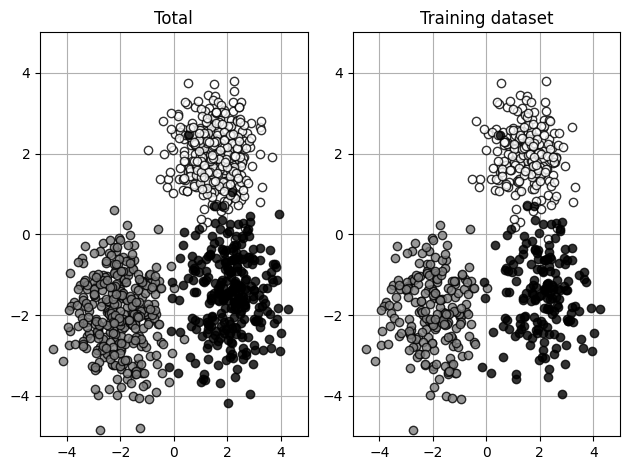

In [13]:
#X0 표시 범위
X_range0 = [-5,5]
#X1 표시 범위
X_range1 = [-5,5]

plt.subplot(1,2,1)
show_data(X,Y)
plt.title('Total')
plt.xlim(X_range0)
plt.ylim(X_range1)

plt.subplot(1,2,2)
show_data(X_train,Y_train)
plt.title('Training dataset')
plt.xlim(X_range0)
plt.ylim(X_range1)

plt.tight_layout()
plt.show()

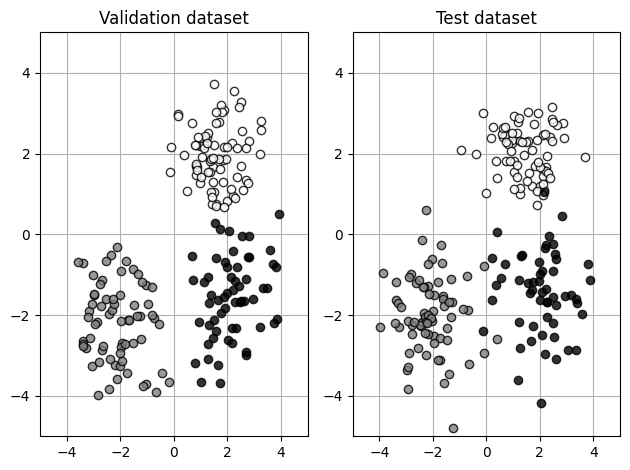

In [14]:
plt.subplot(1,2,1)
show_data(X_valid,Y_valid)
plt.title('Validation dataset')
plt.xlim(X_range0)
plt.ylim(X_range1)

plt.subplot(1,2,2)
show_data(X_test,Y_test)
plt.title('Test dataset')
plt.xlim(X_range0)
plt.ylim(X_range1)

plt.tight_layout()
plt.show()

In [15]:
# -------- 데이터를 'three_class.npz'에 저장
np.savez('three_class.npz', X_train=X_train, Y_train=Y_train,
         X_valid=X_valid, Y_valid=Y_valid,
         X_test=X_test, Y_test=Y_test,
         X_range0=X_range0, X_range1=X_range1)

In [16]:
# 시그모이드 함수 ------------------------
def Sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y

def deriv_Sigmoid(x):
    return x*(1-x)

def MLP_forward(U1, U2, P, C, x):
    N, D = x.shape #입력 차원
    zsum = np.zeros((N,P+1))
    z = np.zeros((N,P+1))
    osum = np.zeros((N,C))
    o = np.zeros((N,C))
    
    for n in range(N):
        #은닉층의 계산
        zsum[n,0] = 1.0
        z[n,0] = 1.0
        
        #for j in range(P):
        #    zsum[n, j+1] = np.dot(U1[j],np.r_[1,x[n]])
        #    z[n,j+1] = Sigmoid(zsum[n, j+1])
        # 순환문 아래의 행렬식으로 가능
        zsum[n,1:] = np.dot(U1, np.r_[1, x[n]])
        z[n] = Sigmoid(zsum[n])
            
        #출력층 계산
        #for k in range(C):
        #    osum[n, k] = np.dot(U2[k],z[n])
        #    o[n,k] = Sigmoid(osum[n, k])
        osum[n] = np.dot(U2, z[n])
        o[n] = Sigmoid(osum[n])
        
    return o, osum, z, zsum

def MLP_backward(U1, U2, P, C, x, y):
    N, D = x.shape #입력 차원
    dU1 = np.zeros_like(U1)
    dU2 = np.zeros_like(U2)
    delta = np.zeros(C)
    eta = np.zeros(P)
    
    o, _, z, _ = MLP_forward(U1,U2,P,C,x)
    #x0 = np.ones((N,1))
    #x = np.concatenate([x0,x], axis=1)
    for n in range(N):
        # 출력층 node의 입력에서 에러값 delta 계산
        #for k in range(C):
        #    delta[k] = (y[n,k]-o[n,k])*deriv_Sigmoid(o[n,k])
        delta = (y[n] - o[n])*deriv_Sigmoid(o[n])
        
        # 은닉층 node의 입력에서 에러값 eta 계산
        sum_err = np.zeros_like(eta)
        #for j in range(P):
        #    for k in range(C):
        #        sum_err[j] = sum_err[j] + U2[k,j+1]*delta[k] #은닉층 j번째 node의 출력에 유입되는 에러값을 계산
        #    eta[j] = sum_err[j]*deriv_Sigmoid(z[n,j+1]) #은닉층 j번째 node의 입력의 에러값 계산
        sum_err = np.dot(U2.T[1:], delta) # j+1 -> 1: 슬라이싱
        eta = sum_err * deriv_Sigmoid(z[n, 1:]) # j+1 -> 1: 슬라이싱
        
        
        # 출력 node와 은닉층 node를 연결하는 edge의 weight 미분값을 계산       
        #for k in range(C):
        #    for j in range(P+1):
        #        dU2[k,j] = dU2[k,j] - z[n,j]*delta[k]/N # 배치 단위의 delta를 더한 후에 N으로 나눠 평균값을 사용
        dU2 = dU2 - np.dot(delta.reshape((-1, 1)) , z[n].reshape((1, -1)))/N
        
               
        # 은닉층 node와 입력층 node를 연결하는 edge의 weight 미분값을 계산
        x_ = np.r_[1,x[n]]
        #for j in range(P):
        #    for i in range(D+1):
        #        dU1[j,i] = dU1[j,i] - x_[i]*eta[j]/N
        dU1 = dU1 - np.dot(eta.reshape((-1, 1)) , x_.reshape((1, -1)))/N

    return dU1, dU2    

def mse_cal(U1, U2, P, C, X, Y):
    N, D = X.shape
    output, _, _, _ = MLP_forward(U1, U2, P, C, X)
    #mse = np.sum((Y.reshape(-1) - output.reshape(-1))**2)/N 
    mse = np.square(Y.reshape(-1)- output.reshape(-1)).mean()
    return mse

In [17]:
def trainingMLP(U1_input, U2_input, batch_size, X_train, X_valid, Y_train, Y_valid, P, C, D):
    rho = 0.01 # learning rate
    epoch = 300
    N = X_train.shape[0] #training dataset size

    U1 = U1_input.copy()
    U2 = U2_input.copy()

    batch_num = X_train.shape[0] // batch_size
    sIdx = np.arange(X_train.shape[0])
    error_train = []
    error_valid = []
    startTime = time.time()
    
    for e in range(epoch):
        print(f"The number of Epoch:{e:04d}\n")
        epochStartTime = time.time()
        
        np.random.shuffle(sIdx)    #training dataset X_train와 Y_train를 같은 순번으로 shuffing시킴
        X_train = X_train[sIdx]
        Y_train = Y_train[sIdx]
        
        #SGD_num = np.random.randint(batch_size)
        #X_mini_batch = X_train[SGD_num]
        #Y_mini_batch = Y_train[SGD_num]
        
        for n in range(batch_num):
            if(n < (batch_num-1)):
                dU1, dU2 = MLP_backward(U1, U2, P, C, X_train[n*batch_size:n*batch_size+batch_size], Y_train[n*batch_size:n*batch_size+batch_size])
            else:
                dU1, dU2 = MLP_backward(U1, U2, P, C, X_train[n*batch_size:], Y_train[n*batch_size:])
            
            # U2 행렬을 업데이트               
            #for k in range(C):
            #    for j in range(P+1):
            #        U2[k,j] = U2[k,j] - rho*dU2[k,j]
            #위의 for문 대신 아래의 한줄로 연산 가능
            U2 = U2 -rho*dU2
            
            #U1 행렬을 업데이트
            #for j in range(P):
            #    for i in range(D+1):
            #        U1[j, i] = U1[j,i] - rho*dU1[j,i]
            #위의 for문 대신 아래의 한줄로 연산 가능
            U1 = U1 -rho*dU1                
        
        e_train = mse_cal(U1, U2, P, C, X_train, Y_train)
        e_valid = mse_cal(U1, U2, P, C, X_valid, Y_valid)
        error_train.append(e_train)
        error_valid.append(e_valid)

        #print(f"Updated U1 Matrix in learning process:\n {U1}\n")
        #print(f"Updated U1 Matrix in learning process:\n {U2}\n")
        
        epoch_calculation_time = time.time() - epochStartTime
        
    
        print(f"[training dataset]\tMSE error : {error_train[e]} | accuracy : {(1-error_train[e])*100}%")
        print(f"[validation dataset]\tMSE error : {error_valid[e]} | accuracy : {(1-error_valid[e])*100}%")
        
        print(f"Epoch[{{e:04d}}] calculation time:{epoch_calculation_time:0.3f} sec\n")
        
        print("###########################\n")

    calculation_time = time.time() - startTime
    print(f"Total calculation time:{calculation_time:0.3f} sec\n")

    print(f"Final Updated U1 Matrix:{U1}\n")
    print(f"Final Updated U1 Matrix:{U2}\n")
    
    return error_train, error_valid, U1, U2

The number of Epoch:0000

[training dataset]	MSE error : 0.27963303661534605 | accuracy : 72.03669633846539%
[validation dataset]	MSE error : 0.28350740007046393 | accuracy : 71.6492599929536%
Epoch[{e:04d}] calculation time:0.185 sec

###########################

The number of Epoch:0001

[training dataset]	MSE error : 0.26878653424402593 | accuracy : 73.12134657559741%
[validation dataset]	MSE error : 0.27213285488163935 | accuracy : 72.78671451183607%
Epoch[{e:04d}] calculation time:0.101 sec

###########################

The number of Epoch:0002

[training dataset]	MSE error : 0.25924055803801926 | accuracy : 74.07594419619808%
[validation dataset]	MSE error : 0.2620905182276768 | accuracy : 73.79094817723232%
Epoch[{e:04d}] calculation time:0.071 sec

###########################

The number of Epoch:0003

[training dataset]	MSE error : 0.25088132052376233 | accuracy : 74.91186794762376%
[validation dataset]	MSE error : 0.25327443588643317 | accuracy : 74.67255641135668%
Epoch[{e:0

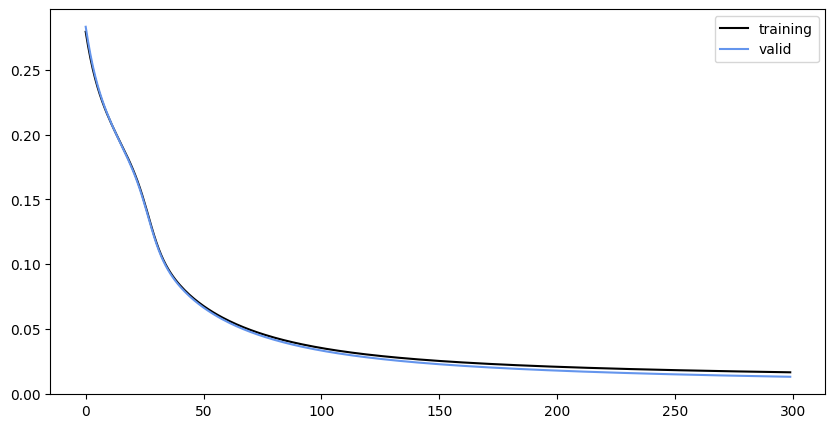

In [18]:
P = 8
C = 3
D = 2

#가중치 초기화
np.random.seed(seed=100)
init_U1 = np.random.randn(P*(D+1))
init_U1 = init_U1.reshape(P,D+1)
init_U2 = np.random.randn(C*(P+1))
init_U2 = init_U2.reshape(C,P+1)

batch_size = 8
err_train, err_valid, U1_8b, U2_8b = trainingMLP(init_U1, init_U2, batch_size, X_train, X_valid, Y_train, Y_valid, P, C, D)

plt.figure(1,figsize=(10,5))
plt.plot(err_train, 'black', label='training')
plt.plot(err_valid,'cornflowerblue', label='valid')
plt.legend()
plt.show()

The number of Epoch:0000

[training dataset]	MSE error : 0.28563267318500146 | accuracy : 71.43673268149986%
[validation dataset]	MSE error : 0.28978386720197 | accuracy : 71.02161327980299%
Epoch[{e:04d}] calculation time:0.274 sec

###########################

The number of Epoch:0001

[training dataset]	MSE error : 0.27977343233464197 | accuracy : 72.0226567665358%
[validation dataset]	MSE error : 0.2836543510024172 | accuracy : 71.63456489975827%
Epoch[{e:04d}] calculation time:0.071 sec

###########################

The number of Epoch:0002

[training dataset]	MSE error : 0.2742463351503735 | accuracy : 72.57536648496266%
[validation dataset]	MSE error : 0.27786254831484686 | accuracy : 72.2137451685153%
Epoch[{e:04d}] calculation time:0.075 sec

###########################

The number of Epoch:0003

[training dataset]	MSE error : 0.2690365689283693 | accuracy : 73.09634310716307%
[validation dataset]	MSE error : 0.27239368451398605 | accuracy : 72.7606315486014%
Epoch[{e:04d}] ca

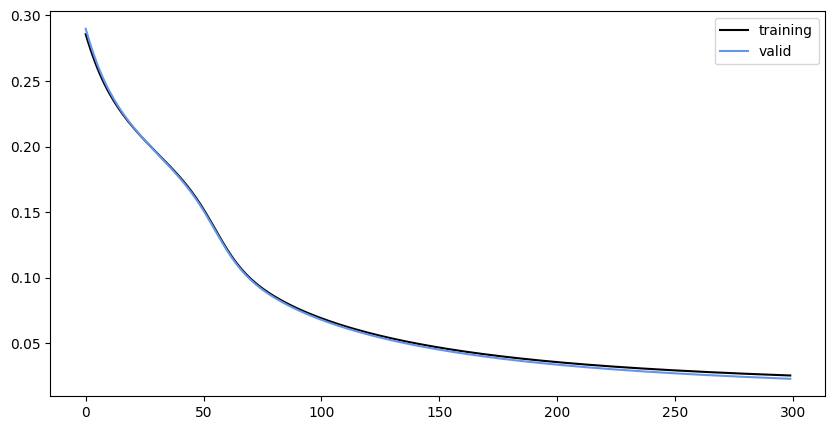

In [19]:
batch_size = 16
err_train, err_valid, U1_16b, U2_16b = trainingMLP(init_U1, init_U2, batch_size, X_train, X_valid, Y_train, Y_valid, P, C, D)

plt.figure(1,figsize=(10,5))
plt.plot(err_train, 'black', label='training')
plt.plot(err_valid,'cornflowerblue', label='valid')
plt.legend()
plt.show()

The number of Epoch:0000



[training dataset]	MSE error : 0.28876669315217957 | accuracy : 71.12333068478205%
[validation dataset]	MSE error : 0.29305976286700847 | accuracy : 70.69402371329916%
Epoch[{e:04d}] calculation time:0.271 sec

###########################

The number of Epoch:0001

[training dataset]	MSE error : 0.2858123015129253 | accuracy : 71.41876984870747%
[validation dataset]	MSE error : 0.28997286493785346 | accuracy : 71.00271350621466%
Epoch[{e:04d}] calculation time:0.168 sec

###########################

The number of Epoch:0002

[training dataset]	MSE error : 0.2829333014858461 | accuracy : 71.70666985141538%
[validation dataset]	MSE error : 0.286962969296648 | accuracy : 71.3037030703352%
Epoch[{e:04d}] calculation time:0.081 sec

###########################

The number of Epoch:0003

[training dataset]	MSE error : 0.28011406738663824 | accuracy : 71.98859326133618%
[validation dataset]	MSE error : 0.2840126553421206 | accuracy : 71.59873446578794%
Epoch[{e:04d}] calculation time:0.100 se

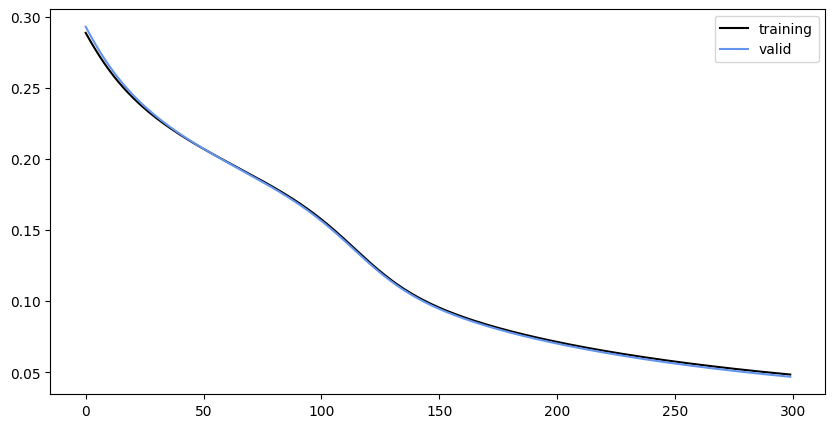

In [20]:
batch_size = 32
err_train, err_valid, U1_32b, U2_32b = trainingMLP(init_U1, init_U2, batch_size, X_train, X_valid, Y_train, Y_valid, P, C, D)

plt.figure(1,figsize=(10,5))
plt.plot(err_train, 'black', label='training')
plt.plot(err_valid,'cornflowerblue', label='valid')
plt.legend()
plt.show()

In [21]:
# 결정 경계 시각화 함수
def Show_MLP_Contour(U1, U2, P, C):
    xn = 60 #등고선 표시 해상도
    x0 = np.linspace(X_range0[0],X_range0[1], xn)
    x1 = np.linspace(X_range1[0],X_range1[1], xn)
    xx0,xx1 = np.meshgrid(x0,x1)
    x = np.c_[np.reshape(xx0,xn*xn), np.reshape(xx1,xn*xn)]
    output, _, _, _ = MLP_forward(U1,U2,P,C,x)
    plt.figure(1, figsize=(4,4))
    for ic in range(C):
        f = output[:,ic]
        f = f.reshape(xn, xn)
        f = f.T
        cont = plt.contour(xx0, xx1, f, levels=[0.8, 0.9],
                           colors=['cornflowerblue', 'black'])
        cont.clabel(fmt='%1.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1) 

accuracy for training dataset:0.9816666666666667

accuracy for test dataset:0.975



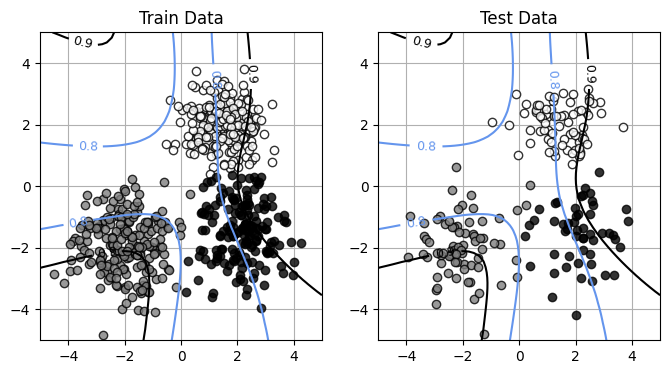

In [22]:
# 학습이 끝난 후 inference 과정, 모델 평가
infer_train, _, _, _ = MLP_forward(U1_16b, U2_16b, P,C,X_train)
infer_test, _, _, _ = MLP_forward(U1_16b, U2_16b, P,C,X_test)

# 확률값이 더 큰 값을 갖게 하는 인덱스를 계산하여 부류를 결정, axis=1 -> 샘플마다 argmax 수행
maxOutputIndex_train = np.argmax(infer_train, axis=1) # 인덱스값을 갖는 1차원 배열
maxOutputIndex_test = np.argmax(infer_test, axis=1)

# 원핫 인코딩 표현으로 변환
# 아래의 Identity matrix에서 행을 선택하여 one-hot encoding으로 변환
#[[1 0],
# [0 1]]
onehotOutput_train = np.eye(Y_train.shape[1])[maxOutputIndex_train] # '0' class -> [1,0], '1' class -> [0,1]
onehotOutput_test = np.eye(Y_train.shape[1])[maxOutputIndex_test]

maxTargetIndex_train = np.argmax(Y_train, axis=1)
maxTargetIndex_test = np.argmax(Y_test, axis=1)

correct_num = 0.0
for n in range(X_train.shape[0]):
    if(maxTargetIndex_train[n] == maxOutputIndex_train[n]):
        correct_num += 1.0
accuracy_train = correct_num/X_train.shape[0]

correct_num = 0.0
for n in range(X_test.shape[0]):
    if(maxTargetIndex_test[n] == maxOutputIndex_test[n]):
        correct_num += 1.0
accuracy_test = correct_num/X_test.shape[0]

print(f'accuracy for training dataset:{accuracy_train}\n')
print(f'accuracy for test dataset:{accuracy_test}\n')

plt.figure(1, figsize=(8,4))
plt.subplot(1,2,1)
show_data(X_train,onehotOutput_train)
Show_MLP_Contour(U1_16b, U2_16b, P, C)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Train Data')
plt.subplot(1,2,2)
show_data(X_test, onehotOutput_test)
Show_MLP_Contour(U1_16b, U2_16b, P, C)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Test Data')
plt.show()